In [5]:
import numpy as np
import pandas as pd

import scipy.cluster.hierarchy as hac

import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [6]:
plotdir = './figures/'

In [7]:
infile = './data/ba-solar-wind-hydro-monthly-1982-2019.csv'

inds_full = pd.read_csv(infile)

In [8]:
BA_list = list(np.unique(inds_full['ba']))
varlist = ['hydro_gen_mwh', 'solar_gen_mwh', 'wind_gen_mwh']

nBA = len(BA_list)

In [9]:
inds = np.zeros((nBA,3,456))

for i,inBA in enumerate(BA_list):
    
    for j,invar in enumerate(varlist):
        
        inds[i][j] = inds_full[(inds_full['ba']==inBA)][invar]

In [10]:
# Note the several Portland locations has been modified
dic_BA_ll = {'AECI': (37.164480, -92.340620),
             'AVA': (47.671840, -117.389130),
             'BPAT': (46.529020, -121.656010),
             'CISO': (35.643670, -118.148440),
             'ERCO': (30.2161924, -97.6923943),
             'IPCO': (43.6188741, -116.2082252),
             'ISNE': (44.186145, -72.638098),
             'LDWP': (34.053345, -117.242349),
             'MISO': (39.9669123, -86.1440167),
             'NEVP': (38.1444834, -115.2250056),
             'NWMT': (46.0135562, -112.5342486),
             'NYIS': (42.6484431, -75.7075906),
             'PACE': (40.515118, -111.679485),
             'PACW': (43.515118, -122.679485),
             'PGE': (45.2160458, -122.6747919),
             'PJM': (41.1217669, -77.418534),
             'PSCO': (38.7512219, -104.9944326),
             'PSEI': (47.9138754, -121.5016751),
             'SPA': (35.5513637, -95.1383404),
             'SRP': (32.448253, -112.076617),
             'SWPP': (37.7525371, -98.448785),
             'TVA': (35.9661769, -83.920636),
             'WACM': (41.3939846, -105.0706003),
             'WALC': (34.448253, -110.076617)}

## 2. combined three sources

In [11]:
dist_matrix = np.zeros((nBA, nBA))

for i in np.arange(nBA):
    for j in np.arange(nBA):
        
        dist_matrix[i,j] = np.corrcoef(inds[i].sum(axis=0), inds[j].sum(axis=0))[0,1]

In [12]:
Z = hac.linkage(dist_matrix)

In [13]:
R = hac.dendrogram(Z,
                   truncate_mode='lastp',  # show only the last p merged clusters
                   p=nBA,  # show only the last p merged clusters
                   no_plot=True,
                   )

temp = {R["leaves"][ii]: BA_list[int(R["leaves"][ii])] for ii in np.arange(len(R["leaves"]))}

def llf(xx):
    return temp[xx]

./figures/fig_clustering_vertical.n5.png


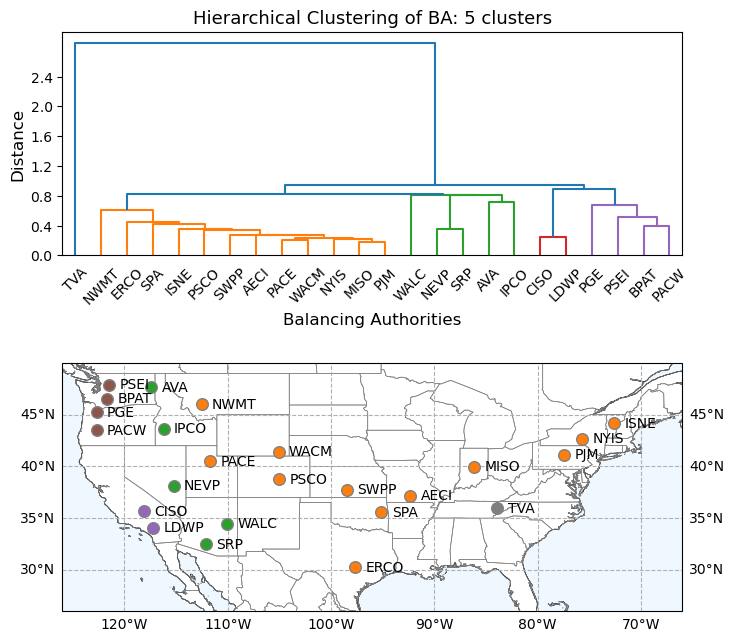

In [14]:
color_threshold, nclusters = 0.82, 5

fig_combo = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((19,10), (0,0), rowspan=7, colspan=10)
ax2 = plt.subplot2grid((19,10), (9,0), rowspan=10, colspan=10, projection=ccrs.PlateCarree())
#[[ax1]] = PlotFuncsXC.crt_subplot2grid_matrix([7,2,10], [1,0,0], [10], [1])
#[[ax2]] = PlotFuncsXC.crt_subplot2grid_matrix([7,2,10], [0,0,1], [10], [1], projection=ccrs.PlateCarree())

# ax1, show dendrogram
hac.dendrogram(Z,
               truncate_mode='lastp',  # show only the last p merged clusters
               p=nBA,  # show only the last p merged clusters
               leaf_label_func=llf,
               leaf_rotation=45,
               leaf_font_size=10,
               show_contracted=False,  # to get a distribution impression in truncated branches
               ax=ax1,
               color_threshold = color_threshold,
               orientation='top'
)

ax1.set_title('Hierarchical Clustering of BA: %d clusters' % nclusters, fontsize=13)
ax1.set_xlabel('Balancing Authorities', fontsize=12)
ax1.set_ylabel('Distance', fontsize=12)
ax1.set_yticks(np.arange(0, 2.40001, 0.4))

labels = hac.fcluster(Z, t=color_threshold, criterion='distance')

# ax2, show map
# background maps
ax2.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
ax2.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='grey', linewidth=0.5,\
                                                    facecolor='none', name='admin_1_states_provinces')
ax2.add_feature(countries, zorder=2)

for i in np.arange(24):
    my_ll = dic_BA_ll[BA_list[i]]
    my_color = matplotlib.cm.tab10(labels[i]/7)
    #print('%2d  %4s  %2d' % (i, BA_list[i], labels[i]))
    ax2.scatter(my_ll[1], my_ll[0], s=70, facecolor=my_color, edgecolor='grey', alpha=1, zorder=3)
    ax2.text(my_ll[1]+1, my_ll[0], BA_list[i], ha='left', va='center')
    
ax2.set_xlim([-126, -66])
ax2.set_ylim([26, 50])

    
# decorations
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=1,
                   x_inline=False, y_inline=False, xlocs=np.arange(-180,171,10), ylocs=np.arange(0,81,5))
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = True

figname = plotdir + 'fig_clustering_vertical.n%d.png' % (nclusters)
print(figname)
#fig_combo.savefig(figname, dpi=600)

plt.show()
plt.close()
del(fig_combo)